#Notebook Proyecto Aprendizaje Profundo
Vicente García Munizaga

Alfredo Medina Klapp

Daniel Sebastián Gaete

# Índice
0. [_Setup_ y librerías](#setup)
1. [Procesamiento y análisis de datos](#parte1)

#0. _Setup_ y librerías <a name="setup"></a>

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import math
import plotly.express as px
from collections import Counter
from os import listdir
from PIL import Image
from os.path import join
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, RandomRotation
import torch.optim as optim
from tqdm import tqdm
import copy

In [ ]:
from IPython.display import clear_output

!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

clear_output()

import os, psutil, humanize
import GPUtil as GPU

GPUs = GPU.getGPUs()
if len(GPUs) > 0:
  gpu = GPUs[0]                  # Only one GPU on Colab and isn’t guaranteed

  def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize(  \
      psutil.virtual_memory().available ), " I Proc size: " + \
      humanize.naturalsize( process.memory_info().rss))

    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | \
      Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, \
      gpu.memoryUtil*100, gpu.memoryTotal))

  printm()
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device: ", device)

Gen RAM Free: 12.1 GB  I Proc size: 505.6 MB
GPU RAM Free: 15101MB | Used: 0MB | Util   0% |       Total 15360MB
device:  cuda


#1. Procesamiento y análisis de datos <a name="parte1"></a>

In [ ]:
!wget https://github.com/brendenlake/omniglot/raw/master/python/images_evaluation.zip
!wget https://github.com/brendenlake/omniglot/raw/master/python/images_background.zip
!unzip -qq images_background.zip
!unzip -qq images_evaluation.zip

--2023-07-05 14:35:27--  https://github.com/brendenlake/omniglot/raw/master/python/images_evaluation.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/brendenlake/omniglot/master/python/images_evaluation.zip [following]
--2023-07-05 14:35:27--  https://raw.githubusercontent.com/brendenlake/omniglot/master/python/images_evaluation.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6462886 (6.2M) [application/zip]
Saving to: ‘images_evaluation.zip’

images_evaluation.z 100%[===================>]   6.16M  --.-KB/s    in 0.08s   

2023-07-05 14:35:28 (78.7 MB/s) - ‘images_evaluation.zip’ saved [6

In [ ]:
TRAIN_IMAGES_DIR_BASE = "images_background"
EVALUATION_IMAGES_DIR_BASE = "images_evaluation"

In [ ]:
## Leemos todas las imágenes de un alfabeto
def get_alphabet_images_path(base_dir, alphabet_dir_name):
    path_to_alphabet_dir = base_dir + "/" + alphabet_dir_name
    characters = os.listdir(path_to_alphabet_dir)
    images_path = []
    for character in characters:
      images_in_dir = os.listdir(path_to_alphabet_dir + "/" + character + "/")
      images_path += [path_to_alphabet_dir + "/" + character + '/' + image_path for image_path in images_in_dir]
    return np.array(images_path)

In [ ]:
## Mostramos las imágenes del input (la cantidad de imágenes
## debe ser un cuadrado perfecto para que quede cuadriculado)
def show_images(images_paths):
  images_per_row = int(math.sqrt(len(images_paths)))
  fig, axs = plt.subplots(images_per_row, images_per_row, figsize=(10, 10))
  for i, image_path in enumerate(images_paths):
      image = plt.imread(image_path)
      row = i // images_per_row
      col = i % images_per_row
      axs[row, col].imshow(image)
      axs[row, col].axis('off')

  plt.tight_layout()
  plt.show()

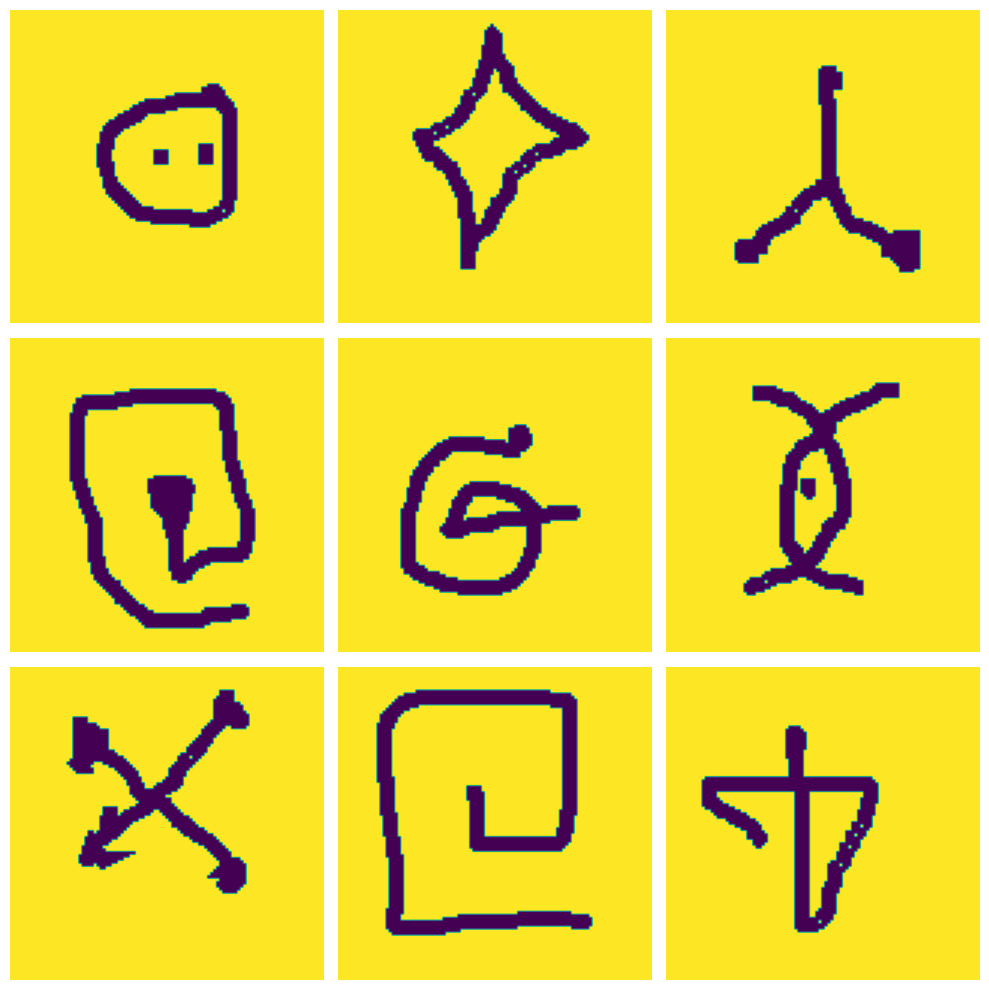

In [ ]:
## Mostramos 9 imágenes random del dataset de entrenamiento
images =  np.random.choice(get_alphabet_images_path(TRAIN_IMAGES_DIR_BASE, "Futurama"), size=9, replace=False)
show_images(images)

In [ ]:
dataset = ImageFolder('/content/images_background')

In [ ]:
dataset_distribution = dict(Counter(dataset.targets))
dataset_distribution_for_plotly = {"Alfabeto (índice)": list(dataset_distribution.keys()), "Número de instancias (imágenes)": list(dataset_distribution.values())}
fig = px.bar(dataset_distribution_for_plotly, x="Alfabeto (índice)", y="Número de instancias (imágenes)")
fig.show()

Los alfabetos no están balanceados porque algunos tienen más caracteres que otros

In [ ]:
class Characters(torch.utils.data.Dataset):
    def __init__(self, dir_files, transform=None):
        self.dir_files = dir_files # array de paths a los caracteres
        self.transform = transform
        self.images = []          # Vincula el indice con un nombre de archivo
        self.imgs_to_class = []     # Vincula el indice con una clase
        self.index_to_class = {}
        self.images, self.imgs_to_class = self.build_indices()

    def build_indices(self):
        class_counter = 0 # Contador para guardar el índice de cada imagen
        image_list = []
        imgs_to_class = []
        for character_directory in self.dir_files:
          if character_directory not in self.index_to_class:
            self.index_to_class[character_directory] = class_counter
            class_counter+=1
          for file in listdir(character_directory):
            image_list.append(file)
            imgs_to_class.append(self.index_to_class[character_directory])

        return image_list, imgs_to_class

    def get_image(self, archivo):
        img = Image.open(archivo)
        return img

    def __getitem__(self, idx):
        file_name = self.images[idx]
        _class = self.imgs_to_class[idx]
        img_path = list(self.index_to_class.keys())[list(self.index_to_class.values()).index(_class)]
        img_path = join(img_path, file_name)
        img = self.get_image(img_path)

        if self.transform is not None:
            img = self.transform(img.convert('RGB')) #algunas imágenes tienen 4 canales (R,G,B,alpha) por la transparencia, así que lo eliminamos y lo dejamos en RGB
        return img, _class

    def __len__(self):
        return len(self.images)

In [ ]:
class LearningAnalyzer():
    def __init__(self, root, model_pretrained, model_non_pretrained, hparams):
        self.root = root
        self.model_non_pretrained = model_non_pretrained
        self.model_pretrained = model_pretrained
        self.hparams = hparams

    def train(self, model, train_loader, test_loader, val_loader):
      loss_fn = nn.CrossEntropyLoss()
      optimizer = optim.SGD(model.parameters(), lr=self.hparams["lr"], momentum=self.hparams["momentum"])
      ovrl_history = {
          'train': {'loss': [], 'acc': []},
          'val': {'acc': []},
      }
      n_epochs = self.hparams["n_epochs"]
      batch_size = self.hparams["batch_size"]
      for epoch in range(n_epochs):
        losses = []
        cum_loss = 0.0
        cum_acc = 0.0
        with tqdm(train_loader, unit='batch', position=0, leave=True) as tepoch:
          tepoch.set_description(f"Epoch {epoch}/{n_epochs}")
          for batch, (data, targets) in enumerate(tepoch, start=1):
            # Explicacion de zero_grad() aqui
            # https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch
            optimizer.zero_grad()
            # print('\n\nData tensor shape:  ', data.shape)
            # print('Class tensor shape: ', targets.shape)
            # Pasamos los datos a GPU
            data = data.to(device)
            targets = targets.to(device)

            # Hacemos las predicciones y calculamos
            # la funcion de perdida
            preds, x = model(data)
            # print(f'Model output shape: ', preds.shape)
            loss = loss_fn(preds, targets)

            # Los gradientes estan guardados en los tensores mismos
            # en el atributo .grad, mas info. en:
            # https://stackoverflow.com/questions/53975717/pytorch-connection-between-loss-backward-and-optimizer-step
            loss.backward()
            optimizer.step()

            # Obtenemos la clase predicha para cada tensor, que corresponde
            # al argmax de la salida del modelo. Aqui tambien podria funcionar
            # un softmax. Mas sobre eso aqui
            # https://discuss.pytorch.org/t/why-the-torch-max-of-predictions-and-f-softmax-pred-are-equal-and-what-is-the-logic-behind-this/141019/2
            _, preds = torch.max(preds, dim=1)
            # print('Predicted classes shape: ', preds.shape)
            cum_acc += torch.sum(preds == targets)

            # Cifras de desempeño
            cum_loss += loss.item()
            curr_loss = cum_loss / batch
            curr_acc = cum_acc / (batch * batch_size)
            tepoch.set_postfix(Loss=curr_loss, Acc=curr_acc.item())
            losses.append(loss.item())

            # Muy importante vaciar el caché después de cada iteración,
            # si no nos vamos a encontrar con un 'CUDA Out of memory"
            # mas temprano que tarde.
            torch.cuda.empty_cache()

          epoch_loss = float(cum_loss / batch)
          epoch_acc = float(cum_acc / (batch * batch_size))

          # Guardamos el loss y accuracy para la epoca
          ovrl_history['train']['loss'].append(epoch_loss)
          ovrl_history['train']['acc'].append(epoch_acc)

          # accuracy en el set de validacion
          val_acc = self.test_model(model, val_loader)
          ovrl_history['val']['acc'].append(val_acc)

      print("Acuraccy set de test: ", self.test_model(model, test_loader))
      return ovrl_history



    ## Código de la ayudantía
    def test_model(self, model, test_dl):
        total_correct = 0.0
        total_samples = 0.0

        for x, target in test_dl:          # Iteramos sobre nuestros datos
            # Inicio de la iteración
            model.eval()                        # Dejamos el modelo en modo evaluación
            with torch.no_grad():               # No se calculará información de gradientes
                                                # en el código de más abajo.
                x = x.cuda()
                target = target.cuda()          # Enviamos nuestros datos a GPU
                output = model(x)               # Hacemos el forward de nuestros datos

                preds = output.argmax(dim=1)             # El máximo valor es nuestra predicción
                correct = (preds == target).sum()      # Acumulamos las correctas durante la época
                total_correct += correct
                total_samples += target.shape[0]        # Sumamos el tamaño del batch

                accuracy = total_correct/total_samples # Acc = correctas/total
        model.train()
        return accuracy

    def generate_report(self):
      ''' Retorna un reporte con los diferentes entrenamientos (diferentes datasets) '''

      ## Primer análisis: todas las imágenes al entrenar y como validación se pasará
      ## las mismas imágenes pero rotadas en 45-60 grados (si las clasifica bien entonces
      ## no está memorizando).
      copy_pretrained = copy.deepcopy(self.model_pretrained)
      copy_non_pretrained = copy.deepcopy(self.model_non_pretrained)

      train_paths = []
      tests_paths = []
      for alphabet in listdir(self.root):
          directory = join(self.root, alphabet)
          for index, character_class in enumerate(listdir(directory)):
            character_directory = join(directory, character_class)
            if index % 2 == 0:
              train_paths.append(character_directory)
            else:
              tests_paths.append(character_directory)


      transform_train = Compose([Resize((self.hparams["input_size"], self.hparams["input_size"])),
                          ToTensor(), Normalize((.5, .5, .5), (.5, .5, .5))])
      transform_val = Compose([Resize((self.hparams["input_size"], self.hparams["input_size"])),
                          ToTensor(), Normalize((.5, .5, .5), (.5, .5, .5)), RandomRotation(degrees=(10, 20))])
      train = Characters(train_paths, transform=transform_train)
      test = Characters(tests_paths, transform=transform_train)
      val = Characters(train_paths, transform=transform_val)
      train_loader = DataLoader(train, batch_size=self.hparams['batch_size'], shuffle=True)
      test_loader = DataLoader(test, batch_size=self.hparams['batch_size'], shuffle=True)
      val_loader = DataLoader(val, batch_size=self.hparams['batch_size'], shuffle=True)


      n_classes = len(train.imgs_to_class)
      copy_pretrained.fc = nn.Linear(copy_pretrained.fc.in_features, n_classes, bias=True)
      copy_non_pretrained.fc = nn.Linear(copy_non_pretrained.fc.in_features, n_classes, bias=True) # usamos el output del backbone y la cantidad de clases para generar el vector clasificador
      copy_pretrained = copy_pretrained.to(device)
      copy_non_pretrained = copy_non_pretrained.to(device)

      pretrained_history = self.train(copy_pretrained, train_loader, test_loader, val_loader)
      non_pretrained_history = self.train(copy_non_pretrained, train_loader,test_loader, val_loader)

      print(pretrained_history)
      print(non_pretrained_history)




In [ ]:
from torchvision.models import inception_v3
model_pretrained = inception_v3(pretrained=True)
model_non_pretrained = inception_v3(pretrained=False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.

/usr/local/lib/python3.10/dist-packages/torchvision/models/inception.py:43: FutureWarning:

The default weight initialization of ince

In [ ]:
# efficientnet_b4_input_size = 380
root = "images_background"
hparams = {"lr": 0.01, "momentum":0.9, "batch_size": 32, "n_epochs": 3, "input_size": 299}
analyzer = LearningAnalyzer(root, model_pretrained, model_non_pretrained, hparams)

In [ ]:
analyzer.generate_report()

Epoch 2/3: 100%|██████████| 305/305 [02:46<00:00,  1.83batch/s, Acc=0.876, Loss=0.477]


Acuraccy set de test:  tensor(0.0162, device='cuda:0')


Epoch 2/3: 100%|██████████| 305/305 [02:44<00:00,  1.86batch/s, Acc=0.276, Loss=3.11]


Acuraccy set de test:  tensor(0.0112, device='cuda:0')
{'train': {'loss': [5.009812513726657, 1.118372588274909, 0.4767099425440929], 'acc': [0.18698769807815552, 0.7165983319282532, 0.8757172226905823]}, 'val': {'acc': [tensor(0.3892, device='cuda:0'), tensor(0.7295, device='cuda:0'), tensor(0.8000, device='cuda:0')]}}
{'train': {'loss': [6.6439745136948885, 4.780058920969728, 3.105907325275609], 'acc': [0.007377048954367638, 0.07438524812459946, 0.27622950077056885]}, 'val': {'acc': [tensor(0.0333, device='cuda:0'), tensor(0.1526, device='cuda:0'), tensor(0.3710, device='cuda:0')]}}


In [ ]:
transform = Compose([Resize((self.hparams["input_size"], 30)), ToTensor(), Normalize((.5, .5, .5), (.5, .5, .5))])
train = Characters(train_paths, transform=transform)

In [ ]:
dataset_distribution = dict(Counter(train.imgs_to_class))
dataset_distribution_for_plotly = {"Clase (índice)": list(dataset_distribution.keys()), "Número de instancias (imágenes)": list(dataset_distribution.values())}
fig = px.bar(dataset_distribution_for_plotly, x="Clase (índice)", y="Número de instancias (imágenes)")
fig.show()

In [ ]:
from torchvision.models import efficientnet_b4

In [ ]:
model = efficientnet_b4(pretrained=True)
n_classes = len(train.index_to_class)
model.classifier = nn.Linear(model.classifier[1].in_features, n_classes, bias=True) #usamos el output del backbone y la cantidad de clases para generar el vector clasificador
model = model.to(device)
print(f'Model running in {device}')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B4_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B4_Weights.DEFAULT` to get the most up-to-date weights.

Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-7eb33cd5.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-7eb33cd5.pth
100%|██████████| 74.5M/74.5M [00:02<00:00, 27.3MB/s]


Model running in cuda


In [ ]:
## Código de la ayudantía
def test_model(model, test_dl):
    total_correctas = 0.0
    total_muestras = 0.0

    for x, target in test_dl:          # Iteramos sobre nuestros datos
        # Inicio de la iteración
        model.eval()                        # Dejamos el modelo en modo evaluación
        with torch.no_grad():               # No se calculará información de gradientes
                                            # en el código de más abajo.
            x = x.cuda()
            target = target.cuda()          # Enviamos nuestros datos a GPU
            output = model(x)               # Hacemos el forward de nuestros datos

            preds = output.argmax(dim=1)             # El máximo valor es nuestra predicción
            correctas = (preds == target).sum()      # Acumulamos las correctas durante la época
            total_correctas += correctas
            total_muestras += target.shape[0]        # Sumamos el tamaño del batch

            accuracy = total_correctas/total_muestras # Acc = correctas/total

    return accuracy

In [ ]:
## Código de la ayudantía
# Declaración de función de pérdida y optimizador
# Puede ser que alguna otra funcion de perdida sea mejor para
# este problema de clasificacion...
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Para guardar los valores que queremos visualizar
ovrl_history = {
    'train': {'loss': [], 'acc': []},
    'val': {'acc': []},
}

n_epochs = 5
for epoch in range(n_epochs):
    losses = []
    cum_loss = 0.0
    cum_acc = 0.0
    with tqdm(train_loader, unit='batch', position=0, leave=True) as tepoch:
      tepoch.set_description(f"Epoch {epoch}/{n_epochs}")
      for batch, (data, targets) in enumerate(tepoch, start=1):
        # Explicacion de zero_grad() aqui
        # https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch
        optimizer.zero_grad()
        # print('\n\nData tensor shape:  ', data.shape)
        # print('Class tensor shape: ', targets.shape)
        # Pasamos los datos a GPU
        data = data.to(device)
        targets = targets.to(device)

        # Hacemos las predicciones y calculamos
        # la funcion de perdida
        preds = model(data)
        # print(f'Model output shape: ', preds.shape)
        loss = loss_fn(preds, targets)

        # Los gradientes estan guardados en los tensores mismos
        # en el atributo .grad, mas info. en:
        # https://stackoverflow.com/questions/53975717/pytorch-connection-between-loss-backward-and-optimizer-step
        loss.backward()
        optimizer.step()

        # Obtenemos la clase predicha para cada tensor, que corresponde
        # al argmax de la salida del modelo. Aqui tambien podria funcionar
        # un softmax. Mas sobre eso aqui
        # https://discuss.pytorch.org/t/why-the-torch-max-of-predictions-and-f-softmax-pred-are-equal-and-what-is-the-logic-behind-this/141019/2
        _, preds = torch.max(preds, dim=1)
        # print('Predicted classes shape: ', preds.shape)
        cum_acc += torch.sum(preds == targets)

        # Cifras de desempeño
        cum_loss += loss.item()
        curr_loss = cum_loss / batch
        curr_acc = cum_acc / (batch * batch_size)
        tepoch.set_postfix(Loss=curr_loss, Acc=curr_acc.item())
        losses.append(loss.item())

        # Muy importante vaciar el caché después de cada iteración,
        # si no nos vamos a encontrar con un 'CUDA Out of memory"
        # mas temprano que tarde.
        torch.cuda.empty_cache()

    epoch_loss = float(cum_loss / batch)
    epoch_acc = float(cum_acc / (batch * batch_size))

    # Guardamos el loss y accuracy para la epoca
    ovrl_history['train']['loss'].append(epoch_loss)
    ovrl_history['train']['acc'].append(epoch_acc)

    # y accuracy en el set de validacion
    val_acc = test_model(model, val_loader)
    ovrl_history['val']['acc'].append(val_acc)


    print(f'Epoch {epoch + 1} finished\n')

In [ ]:
transform = Compose([Resize((30, 30)), ToTensor(), Normalize((.5, .5, .5), (.5, .5, .5))])
train = Characters('images_background', transform=transform)
val = Characters('images_background', transform=transform, test=True, )
batch_size = 32
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=True)